In [45]:
import pandas as pd
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [46]:
data = sio.loadmat('./data/GAIT080624-01/gait_recording_080624_walk2.mat')
insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [34]:
def compute_foot_center(frame, rows=64, cols=16, order='F'):
    """
    Given a flattened frame (of length rows*cols), reshape it to (rows,cols)
    and compute the median x,y coordinate from the indices where pressure > 0.
    
    Returns:
        x_center, y_center: The median (x,y) coordinate.
    """
    frame_matrix = frame.reshape((rows, cols), order=order)
    idx = np.where(frame_matrix > 0)
    
    if idx[0].size == 0:
        return np.nan, np.nan

    # idx[0] contains row indices (y) and idx[1] contains column indices (x)
    x_center = np.median(idx[1])
    y_center = np.median(idx[0])
    return x_center, y_center

In [47]:
num_samples = 1000  # Number of frames to sample for calculating a stable foot center

# If there are fewer frames than 1000, use all of them.
num_samples = min(num_samples, insoleAll_l.shape[0], insoleAll_r.shape[0])

np.random.seed(42)  # For reproducibility
indices_l = np.random.choice(insoleAll_l.shape[0], size=num_samples, replace=False)
indices_r = np.random.choice(insoleAll_r.shape[0], size=num_samples, replace=False)

# Collect centers from the random samples.
centers_l = [compute_foot_center(insoleAll_l[i, :], rows=64, cols=16, order='F') for i in indices_l]
centers_r = [compute_foot_center(insoleAll_r[i, :], rows=64, cols=16, order='F') for i in indices_r]

centers_l = np.array(centers_l)  # Shape: (num_samples, 2) with columns [x, y]
centers_r = np.array(centers_r)

# Compute the median of the centers across the sample frames.
foot_center_l = np.nanmedian(centers_l, axis=0)  # [x_center, y_center] for left foot
foot_center_r = np.nanmedian(centers_r, axis=0)  # [x_center, y_center] for right foot

print("Session-wide Left Foot Center (x, y):", foot_center_l)
print("Session-wide Right Foot Center (x, y):", foot_center_r)

Session-wide Left Foot Center (x, y): [ 8. 37.]
Session-wide Right Foot Center (x, y): [ 7. 32.]


In [44]:
# Think about segmenting by forefoot, midfoot, hindfoot

# Think about segmenting by nerve distribution

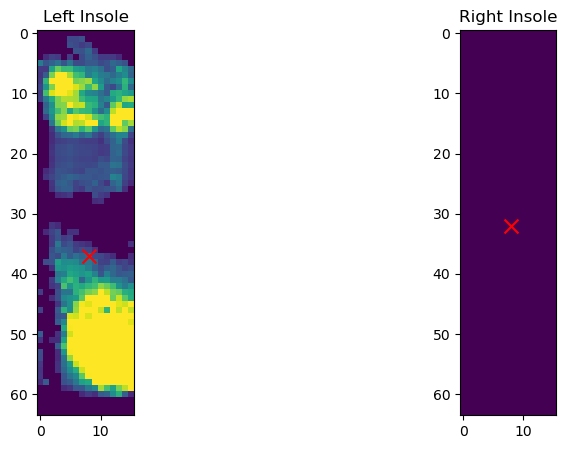

In [48]:
# Choose a specific frame to display (here, index 1000).
frame_index = 5000

# Left Insole Heatmap: reshape
insole_l = insoleAll_l[frame_index]
img_l = np.reshape(insole_l, (64, 16), order='F')

# Right Insole Heatmap: reshape
insole_r = insoleAll_r[frame_index]
img_r = np.reshape(insole_r, (64, 16), order='F')
img_r = np.fliplr(img_r)

# When plotting the right insole, adjust the foot center's x coordinate
# because the image was flipped. For a 16-column image, the new x coordinate is:
# new_x = (num_columns - 1) - original_x.
foot_center_r = ( (16 - 1) - foot_center_r[0], foot_center_r[1] )

# Create the subplots.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot.
axs[0].imshow(img_l)
# Overlay the left foot center as a red 'x'.
axs[0].scatter(foot_center_l[0], foot_center_l[1], color='red', marker='x', s=100)
axs[0].set_title("Left Insole")

# Right Insole Plot.
axs[1].imshow(img_r)
# Overlay the adjusted right foot center as a red 'x'.
axs[1].scatter(foot_center_r[0], foot_center_r[1], color='red', marker='x', s=100)
axs[1].set_title("Right Insole")

plt.show()

KeyboardInterrupt: 

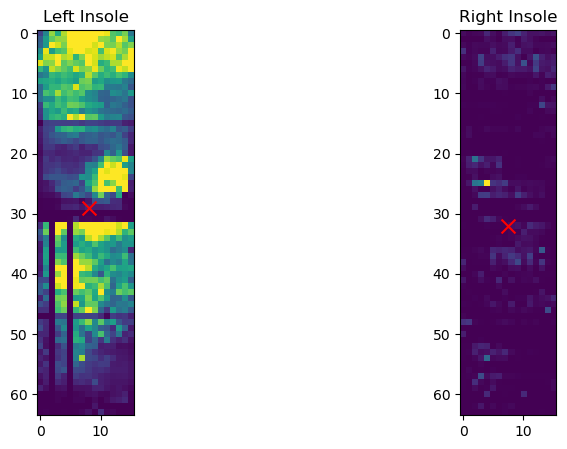

In [43]:
# Assuming 'insoleAll_l' and 'insoleAll_r' are NumPy arrays
# For example, they should have shape (num_frames, 1024) for 64x16 heatmaps per frame
num_frames = 600  # Number of frames in your data

# Set up the figure and axis for both left and right insoles
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the initial heatmap plots for both left and right insoles
img_l = axs[0].imshow(np.zeros((64, 16)), cmap='viridis')
axs[0].set_title("Left Insole")

img_r = axs[1].imshow(np.zeros((64, 16)), cmap='viridis')
axs[1].set_title("Right Insole")

# Insert foot center markers
sc_l = axs[0].scatter(foot_center_l[0], foot_center_l[1], color='red', marker='x', s=100)
sc_r = axs[1].scatter(foot_center_r[0], foot_center_r[1], color='red', marker='x', s=100)

# Function to update the heatmaps for each frame
def update(frame):
    # Left Insole Heatmap
    insole_l = insoleAll_l[frame]  # Get the left insole data for current frame
    img_l_data = np.reshape(insole_l, (64, 16), order='F')
    
    # Right Insole Heatmap
    insole_r = insoleAll_r[frame]  # Get the right insole data for current frame
    img_r_data = np.reshape(insole_r, (64, 16), order='F')
    img_r_data = np.fliplr(img_r_data)  # Flip the right insole image left-right

    # Update heatmap data for each subplot
    axs[0].imshow(img_l_data)
    axs[1].imshow(img_r_data)

    return [img_l, img_r, sc_l, sc_r]

# Create the animation using FuncAnimation
anim = FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)

# Display the animation
anim.save('walking_anim.mp4', writer = 'ffmpeg', fps = 60)